In [1]:
# MODIFY! 
# use RobustScaler! 
model_name = 'rf-wo'

# Import Libraries & Data 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data/d-wo-ns.csv')
X = df.drop('throughput',axis=1)
y = df['throughput']

---

# Scale Data

In [4]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the data
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler()

In [5]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Determine Hyperparameters

## Determine Max Features

In [6]:
# MODIFY!
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(warm_start=True)
model

RandomForestRegressor(warm_start=True)

In [7]:
p_grid = {
    'max_features':['auto', 'sqrt', 'log2']
}

In [8]:
from sklearn.model_selection import GridSearchCV

In [9]:
grid_model = GridSearchCV(
    estimator=model,
    param_grid =p_grid, 
    scoring='neg_mean_squared_error',
    cv=10, 
    verbose=1
)

In [10]:
grid_model.fit(X_train,y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   41.1s finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(warm_start=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2']},
             scoring='neg_mean_squared_error', verbose=1)

In [11]:
grid_model.best_params_

{'max_features': 'auto'}

In [12]:
hp = pd.Series(name=f'{model_name} HP', data=grid_model.best_params_)

In [13]:
hp

max_features    auto
Name: rf-wo HP, dtype: object

In [14]:
hp.to_csv(f'./hyperparameters/{model_name}.csv')

## Determine Number of Estimators

In [15]:
# MODIFY!
import time

estimators = [5,10,25,50,100,500,1000,2000]
scores_list = []

from sklearn.ensemble import RandomForestRegressor

for e in estimators: 
    start = time.time()
    print(f'Starting {e} estimators')
    score_model = RandomForestRegressor(
        n_estimators=e,
        max_features=grid_model.best_params_['max_features']
    )
    
    from sklearn.model_selection import cross_validate

    scores = cross_validate(
        score_model, 
        X_train, 
        y_train,
        scoring=[
            'neg_mean_absolute_error',
            'neg_mean_squared_error',
            'neg_root_mean_squared_error'
        ],
        cv=10
    )
    
    scores = pd.DataFrame(scores)
    scores
    mean_scores = scores.mean()
    scores_list.append(mean_scores)
    print(f'Done with {e} estimators')
    end = time.time()
    print(f'Elapsed time: {end - start}')
    print('\n')

Starting 5 estimators
Done with 5 estimators
Elapsed time: 1.236799955368042


Starting 10 estimators
Done with 10 estimators
Elapsed time: 2.6400070190429688


Starting 25 estimators
Done with 25 estimators
Elapsed time: 6.612130165100098


Starting 50 estimators
Done with 50 estimators
Elapsed time: 13.688124895095825


Starting 100 estimators
Done with 100 estimators
Elapsed time: 36.845587968826294


Starting 500 estimators
Done with 500 estimators
Elapsed time: 135.07026624679565


Starting 1000 estimators
Done with 1000 estimators
Elapsed time: 277.29677629470825


Starting 2000 estimators
Done with 2000 estimators
Elapsed time: 878.5012316703796




In [16]:
scores_df = pd.DataFrame(scores_list)

In [17]:
scores_df

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.119671,0.002635,-3.125925,-18.644486,-4.299634
1,0.258443,0.004684,-2.946729,-16.584305,-4.056515
2,0.652433,0.007206,-2.847037,-15.995878,-3.977351
3,1.357082,0.009699,-2.806508,-15.439988,-3.911482
4,3.656144,0.022416,-2.802221,-15.320498,-3.892672
5,13.386755,0.107348,-2.794322,-15.233645,-3.883828
6,27.190433,0.509859,-2.784674,-15.155449,-3.873163
7,86.399851,1.353533,-2.783271,-15.140688,-3.871777


In [18]:
scores_df['Est'] = estimators

In [19]:
scores_df

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,Est
0,0.119671,0.002635,-3.125925,-18.644486,-4.299634,5
1,0.258443,0.004684,-2.946729,-16.584305,-4.056515,10
2,0.652433,0.007206,-2.847037,-15.995878,-3.977351,25
3,1.357082,0.009699,-2.806508,-15.439988,-3.911482,50
4,3.656144,0.022416,-2.802221,-15.320498,-3.892672,100
5,13.386755,0.107348,-2.794322,-15.233645,-3.883828,500
6,27.190433,0.509859,-2.784674,-15.155449,-3.873163,1000
7,86.399851,1.353533,-2.783271,-15.140688,-3.871777,2000


# Export Scores for Number of Estimators

In [20]:
# mean_scores

In [21]:
scores_df = scores_df.rename(columns={
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [22]:
scores_df

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,0.119671,0.002635,-3.125925,-18.644486,-4.299634,5
1,0.258443,0.004684,-2.946729,-16.584305,-4.056515,10
2,0.652433,0.007206,-2.847037,-15.995878,-3.977351,25
3,1.357082,0.009699,-2.806508,-15.439988,-3.911482,50
4,3.656144,0.022416,-2.802221,-15.320498,-3.892672,100
5,13.386755,0.107348,-2.794322,-15.233645,-3.883828,500
6,27.190433,0.509859,-2.784674,-15.155449,-3.873163,1000
7,86.399851,1.353533,-2.783271,-15.140688,-3.871777,2000


In [23]:
scores_df[['MAE','MSE','RMSE']] = scores_df[['MAE','MSE','RMSE']].apply(lambda x : abs(x))

In [24]:
scores_df
# we go for 25 estimations. Note that from 25 -> 50 estimations the error metrics worsen

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,0.119671,0.002635,3.125925,18.644486,4.299634,5
1,0.258443,0.004684,2.946729,16.584305,4.056515,10
2,0.652433,0.007206,2.847037,15.995878,3.977351,25
3,1.357082,0.009699,2.806508,15.439988,3.911482,50
4,3.656144,0.022416,2.802221,15.320498,3.892672,100
5,13.386755,0.107348,2.794322,15.233645,3.883828,500
6,27.190433,0.509859,2.784674,15.155449,3.873163,1000
7,86.399851,1.353533,2.783271,15.140688,3.871777,2000


In [25]:
scores_df.to_csv(f'./est-scores/{model_name}-est.csv')

In [26]:
pct_scores_df = scores_df.pct_change()

In [27]:
pct_scores_df

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,NaN,NaN,NaN,NaN,NaN,NaN
1,1.159608,0.777576,-0.057326,-0.110498,-0.056544,1.0
2,1.524471,0.538332,-0.033832,-0.035481,-0.019515,1.5
3,1.080032,0.345916,-0.014235,-0.034752,-0.016561,1.0
4,1.694122,1.311227,-0.001528,-0.007739,-0.004809,1.0
5,2.661441,3.788797,-0.002819,-0.005669,-0.002272,4.0
6,1.031144,3.749594,-0.003452,-0.005133,-0.002746,1.0
7,2.177583,1.654722,-0.000504,-0.000974,-0.000358,1.0


In [28]:
pct_scores_df.style.background_gradient() 
# we choose index 4, 100 Estimations <- 
    # Score time decrease 3->4 & Score time increase dramatically 4->5
    # unsubstantial decrease MSE & RMSE 4->5 compared to 3->4

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,nan,nan,nan,nan,nan,nan
1,1.159608,0.777576,-0.057326,-0.110498,-0.056544,1.000000
2,1.524471,0.538332,-0.033832,-0.035481,-0.019515,1.500000
3,1.080032,0.345916,-0.014235,-0.034752,-0.016561,1.000000
4,1.694122,1.311227,-0.001528,-0.007739,-0.004809,1.000000
5,2.661441,3.788797,-0.002819,-0.005669,-0.002272,4.000000
6,1.031144,3.749594,-0.003452,-0.005133,-0.002746,1.000000
7,2.177583,1.654722,-0.000504,-0.000974,-0.000358,1.000000


# Score Model

In [29]:
# MODIFY!
# adopt number of estimators from the previous section

score_model = RandomForestRegressor(n_estimators=100,warm_start=True)
score_model

RandomForestRegressor(warm_start=True)

In [30]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    score_model, 
    X_train, 
    y_train,
    scoring=[
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ],
    cv=10
)

In [31]:
scores = pd.DataFrame(scores)

In [32]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,2.190448,0.013283,-2.469003,-11.824437,-3.438668
1,1.985458,0.012959,-3.469282,-23.811194,-4.879672
2,2.004330,0.013030,-2.895460,-17.328755,-4.162782
3,2.278362,0.016528,-2.727926,-14.154308,-3.762221
4,2.072069,0.013097,-2.599469,-13.416121,-3.662802
5,1.974104,0.012826,-2.699191,-15.247086,-3.904752
6,2.021539,0.013182,-2.919053,-16.456560,-4.056669
7,2.034071,0.012876,-2.679889,-13.673727,-3.697800
8,2.039498,0.012128,-2.760547,-14.086602,-3.753212
9,2.020625,0.012451,-2.643053,-12.559106,-3.543883


In [33]:
mean_scores = scores.mean()

In [34]:
mean_scores

fit_time                             2.062050
score_time                           0.013236
test_neg_mean_absolute_error        -2.786287
test_neg_mean_squared_error        -15.255789
test_neg_root_mean_squared_error    -3.886246
dtype: float64

# Export Model Scores

In [35]:
mean_scores = mean_scores.rename(f'{model_name}')

In [36]:
mean_scores[[2,3,4]] = mean_scores[[2,3,4]].apply(abs)

In [37]:
# mean_scores

In [38]:
mean_scores = mean_scores.rename({
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [39]:
mean_scores

Fit Time       2.062050
Score Time     0.013236
MAE            2.786287
MSE           15.255789
RMSE           3.886246
Name: rf-wo, dtype: float64

In [40]:
mean_scores['STD FT'] = scores.fit_time.std()
mean_scores['STD ST'] = scores.score_time.std()
mean_scores['STD MAE'] = scores.test_neg_mean_absolute_error.std()
mean_scores['STD MSE'] = scores.test_neg_mean_squared_error.std()
mean_scores['STD RMSE'] = scores.test_neg_root_mean_squared_error.std()

In [41]:
mean_scores

Fit Time       2.062050
Score Time     0.013236
MAE            2.786287
MSE           15.255789
RMSE           3.886246
STD FT         0.097159
STD ST         0.001207
STD MAE        0.273879
STD MSE        3.439120
STD RMSE       0.412150
Name: rf-wo, dtype: float64

In [42]:
mean_scores.to_csv(f'./scores/{model_name}.csv')

# Holdout Test

In [43]:
score_model.fit(X_train,y_train)

RandomForestRegressor(warm_start=True)

In [44]:
y_holdout = score_model.predict(X_test)

<AxesSubplot:ylabel='Count'>

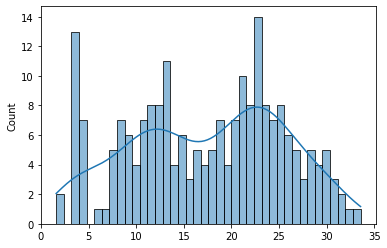

In [45]:
sns.histplot(y_holdout,bins=40,kde=True)

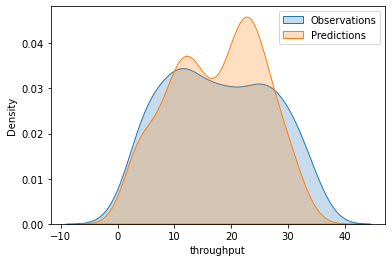

In [46]:
fig,ax = plt.subplots()

sns.kdeplot(y_test, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_holdout, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

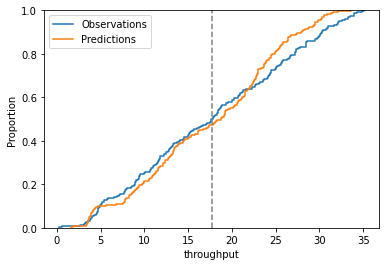

In [47]:
fig,ax = plt.subplots()

sns.ecdfplot(y_test, ax=ax, label='Observations')
sns.ecdfplot(y_holdout, ax=ax,label='Predictions')
plt.axvline(x=y_test.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test,y_holdout)
mse = mean_squared_error(y_test,y_holdout)
rmse = np.sqrt(mse)

In [49]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,rf-wo
MAE,2.916196
MSE,17.102741
RMSE,4.135546


In [50]:
err_df.to_csv(f'./holdout-test/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [51]:
res = y_test - y_holdout
res.describe().drop('count')

mean     0.260167
std      4.136986
min    -14.001568
25%     -1.568287
50%      0.347095
75%      2.335620
max     20.022826
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

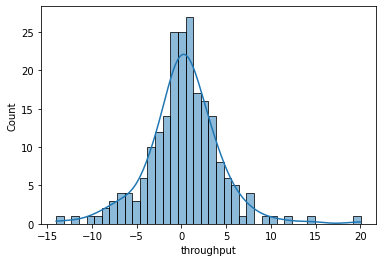

In [52]:
sns.histplot(data=res, kde=True,bins=40)

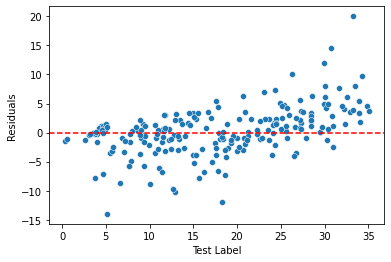

In [53]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

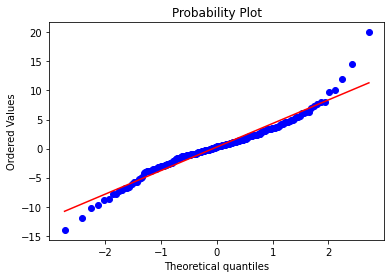

In [54]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

# Export Optimized Model

In [55]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X)

RobustScaler()

In [56]:
# MODIFY! 
X = scaler.transform(X)

op_model = score_model

op_model.fit(X,y)

/Users/aceituno/opt/anaconda3/envs/sml/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:368: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


RandomForestRegressor(warm_start=True)

In [57]:
y_pred = op_model.predict(X)

<AxesSubplot:ylabel='Count'>

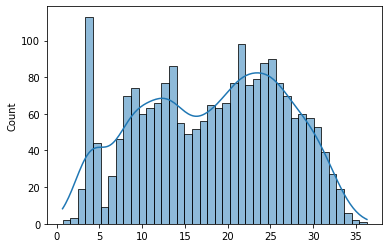

In [58]:
sns.histplot(y_pred,bins=40,kde=True)

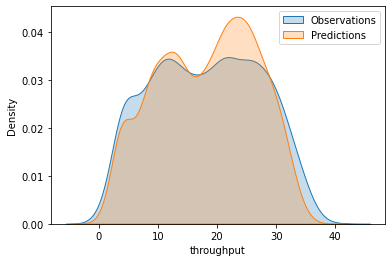

In [59]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

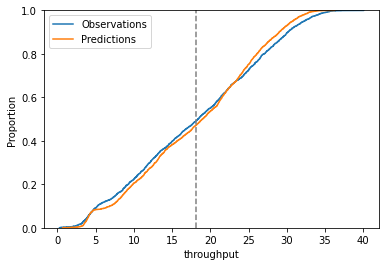

In [60]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [61]:
mae = mean_absolute_error(y,y_pred)
mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)

In [62]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,rf-wo
MAE,1.470831
MSE,4.833599
RMSE,2.198545


In [63]:
err_df.to_csv(f'./model-err/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [64]:
from joblib import dump, load
dump(op_model, f'./opt-models/{model_name}.joblib')

['./opt-models/rf-wo.joblib']

In [65]:
res = y - y_pred
res.describe().drop('count')

mean    -0.051809
std      2.198447
min    -13.568784
25%     -0.953671
50%      0.005557
75%      0.972635
max     19.880943
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

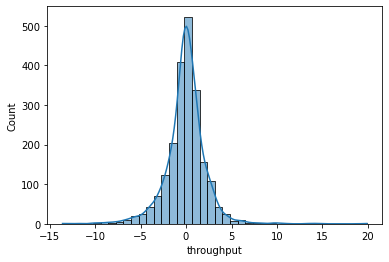

In [66]:
sns.histplot(data=res, kde=True,bins=40)

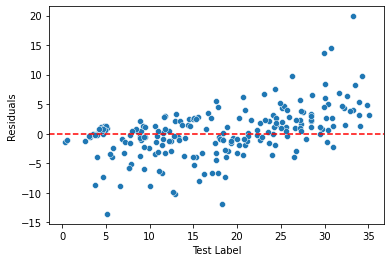

In [67]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

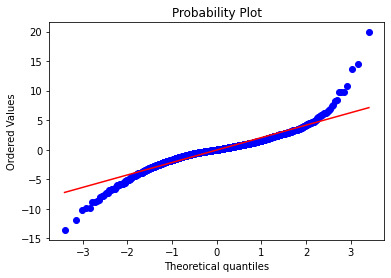

In [68]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

DONE!